In [20]:
import os
import sys

In [21]:
#sys.path.insert(0, '/Users/marusy/Programming/another-fem-framework/')
sys.path.insert(0, '/home/lshtanko/Programming/another-fem-framework/')
#sys.path.insert(0, '/Users/leonshting/Programming/Schlumberger/fem-framework/')

In [22]:
import numpy as np
from interpolant.cell_to_points import Cell2PointsConverter
from interpolant.strict import StrictSolve
from interpolant.opt import OptSolve
from common.helpers import *
from interpolant.helpers import *
from matplotlib import pyplot as plt
%matplotlib inline

In [23]:
np.set_printoptions(linewidth=500, precision=3)

In [24]:
c2p = Cell2PointsConverter(orders=[[2],[2,2]])

In [25]:
strict_solve = StrictSolve(points=c2p.get_points(), weights=c2p.get_diag_weights(), verbose=True)

In [26]:
strict_solve.fit_strict(max_power=strict_solve.get_max_pow(risky=1), method='svd')

Number of equations: 16
Number of degrees of freedom: 15
Strictly stitched_power: 1
Start solving strict part
[False False False False False False False False False False False False  True  True  True]
Nullspace shape: (15, 3)
End solving strict part
NullspaceRank: 3


In [27]:
interps = strict_solve.get_interpolants()
wgths = strict_solve.get_weight_matrices()

In [28]:
opt_solve = OptSolve(matrices=interps,
                     points=c2p.get_points(),
                     strict_power=strict_solve.get_max_pow(risky=1),
                     weights_matrices=wgths,
                     verbose=True
                    )

In [29]:
opt_solve.fit_opt(constraints=True, tr_fun_option='chebyshev', orders_forwards=1)

In [ ]:
opt_solve.restart_opt(tolerance=1e-3)

In [30]:
I_rl = np.array(opt_solve.I_rl_subbed_symm).astype(np.float64)
I_lr = np.array(opt_solve.I_lr_subbed_symm).astype(np.float64)

In [31]:
I_rl

array([[ 0.565,  0.719, -0.068, -0.281,  0.065],
       [-0.032,  0.39 ,  0.284,  0.39 , -0.032],
       [ 0.065, -0.281, -0.068,  0.719,  0.565]])

In [32]:
tr_f = np.vectorize(lambda x: (x-1)*(x-0.5))

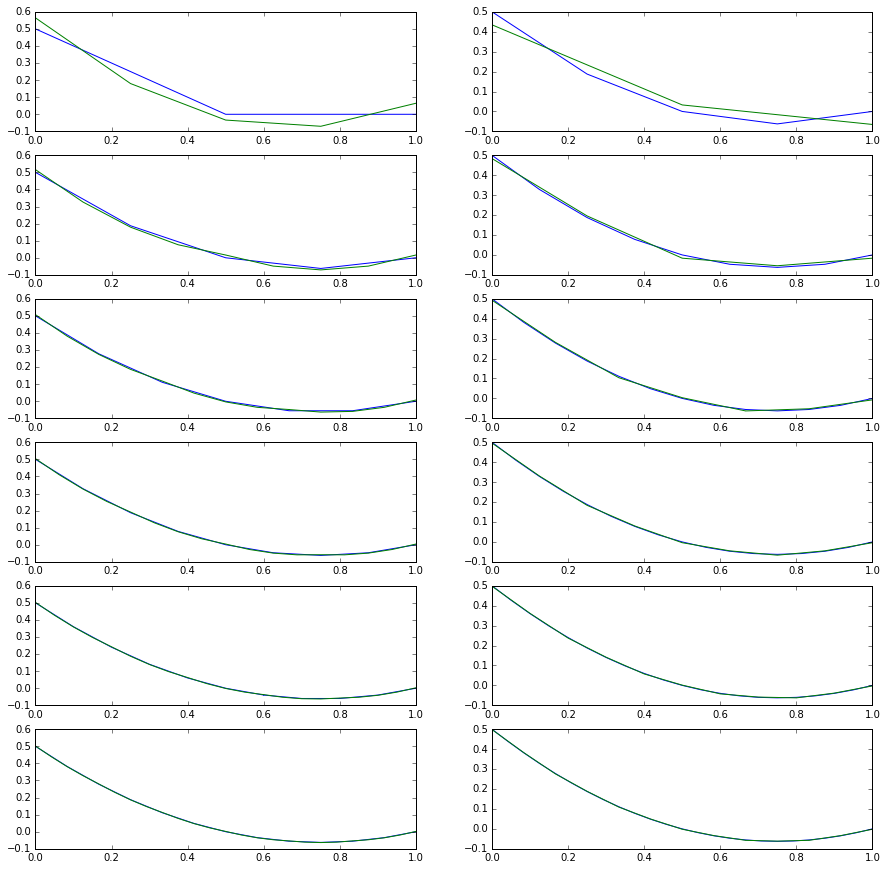

In [33]:
eps_l, eps_r = convergence_test(I_lr=I_lr,
                                I_rl=I_rl,
                                p_l=opt_solve.points[0],
                                p_r=opt_solve.points[1],
                                init_size=(0,1),
                                tr_f=tr_f,
                                weights=[np.array(strict_solve.W_l), np.array(strict_solve.W_r)],
                                div_lim=7)

In [ ]:
explosion_test(I_lr=I_lr,
               I_rl=I_rl,
               p_l=opt_solve.points[0],
               p_r=opt_solve.points[1],
               tr_f=tr_f,
               reps=3)

In [ ]:
plt.semilogy(range(len(eps_l)), eps_l)
plt.semilogy(range(len(eps_r)), eps_r)
plt.semilogy(np.linspace(0, len(eps_r)), float(eps_r[0])*np.exp(-np.linspace(0, len(eps_r))))
plt.semilogy(np.linspace(0, len(eps_r)), float(eps_r[0])*np.exp(-2*np.linspace(0, len(eps_r))))

In [34]:
np.abs(np.linalg.eigvals(np.dot(I_rl, I_lr)))

array([ 0.845,  1.   ,  1.   ])

In [ ]:
np.save(arr=I_lr, file='../datasources/4_lr')
np.save(arr=I_rl, file='../datasources/4_rl')

In [ ]:
I_rl

In [17]:
np.load('../datasources/3_lr.npy')

array([[ 1.103, -0.229,  0.229, -0.103],
       [ 0.335,  0.81 , -0.214,  0.069],
       [-0.138,  1.021,  0.133, -0.017],
       [-0.125,  0.625,  0.625, -0.125],
       [-0.017,  0.133,  1.021, -0.138],
       [ 0.069, -0.214,  0.81 ,  0.335],
       [-0.103,  0.229, -0.229,  1.103]])

In [18]:
I_lr

array([[ 1.1  , -0.224,  0.224, -0.1  ],
       [ 0.336,  0.807, -0.211,  0.068],
       [-0.139,  1.025,  0.13 , -0.015],
       [-0.125,  0.625,  0.625, -0.125],
       [-0.015,  0.13 ,  1.025, -0.139],
       [ 0.068, -0.211,  0.807,  0.336],
       [-0.1  ,  0.224, -0.224,  1.1  ]])